In [1]:
!pip -q install langchain huggingface_hub openai chromadb tiktoken faiss-cpu
!pip -q install sentence_transformers
!pip -q install -U FlagEmbedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install -q langchain-google-genai

In [7]:
!pip install -q langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.9 MB/s eta 0:00:00


In [2]:
!mkdir -p blog_posts
!unzip -q /content/langchain_blog_posts.zip -d blog_posts

In [3]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [8]:
from langchain.vectorstores import FAISS

from langchain.schema import Document
from langchain.vectorstores import Chroma

## Text Splitting & Docloader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.document_loaders import TextLoader

from langchain_google_genai import GoogleGenerativeAIEmbeddings

## BGE Embeddings

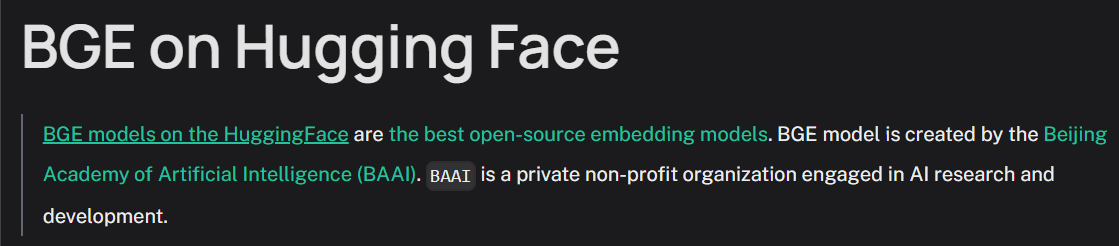

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs=encode_kwargs
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Data prep


In [10]:
loaders = [
    TextLoader('/content/blog_posts/blog.langchain.dev_announcing-langsmith_.txt'),
    TextLoader('/content/blog_posts/blog.langchain.dev_benchmarking-question-answering-over-csv-data_.txt'),
]
docs = []
for l in loaders:
    docs.extend(l.load())

In [11]:
len(docs)

2

In [12]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

In [13]:
# Helper function for printing docs

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [14]:
retriever = FAISS.from_documents(texts,
                                 bge_embeddings
                                #  GoogleGenerativeAIEmbeddings(model="models/embedding-001")
                                 ).as_retriever()

docs = retriever.get_relevant_documents("What is LangSmith?")
#lets look at the docs
pretty_print_docs(docs)

Document 1:

“Because we are building financial products, the bar for accuracy, personalization, and security is particularly high. LangSmith helps us build products we are confident putting in front of users.”

We can’t wait to bring these benefits to more teams. And we’ve got a long list of features on the roadmap like analytics, playgrounds, collaboration, in-context learning, prompt creation, and more.
----------------------------------------------------------------------------------------------------
Document 2:

URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “n

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [23]:
retriever_for_google = FAISS.from_documents(texts,
                                  GoogleGenerativeAIEmbeddings(model="models/embedding-001")
                                 ).as_retriever()

docs_for_google = retriever_for_google.get_relevant_documents("What is LangSmith?")
#lets look at the docs
pretty_print_docs(docs_for_google)

Document 1:

The blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main issue that we see today is application performance–something that works ~30% of the time is good enough for a Twitter demo, but not nearly good enough for production.

Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.

LangSmith is now in closed beta. So if you’re looking for a robust, unified, system for debugging, testing, evaluating, and monitoring your LLM applications, sign up here.



How did we get here?
----------------------------------------------------------------------------------------------------
Document 2:

“Thanks to Langchain smith we were able to analyze our LLM calls, underst

## Adding contextual compression with an LLMChainExtractor

Now let's wrap our base retriever with a ContextualCompressionRetriever. We'll add an LLMChainExtractor, which will iterate over the initially returned documents and extract from each only the content that is relevant to the query.

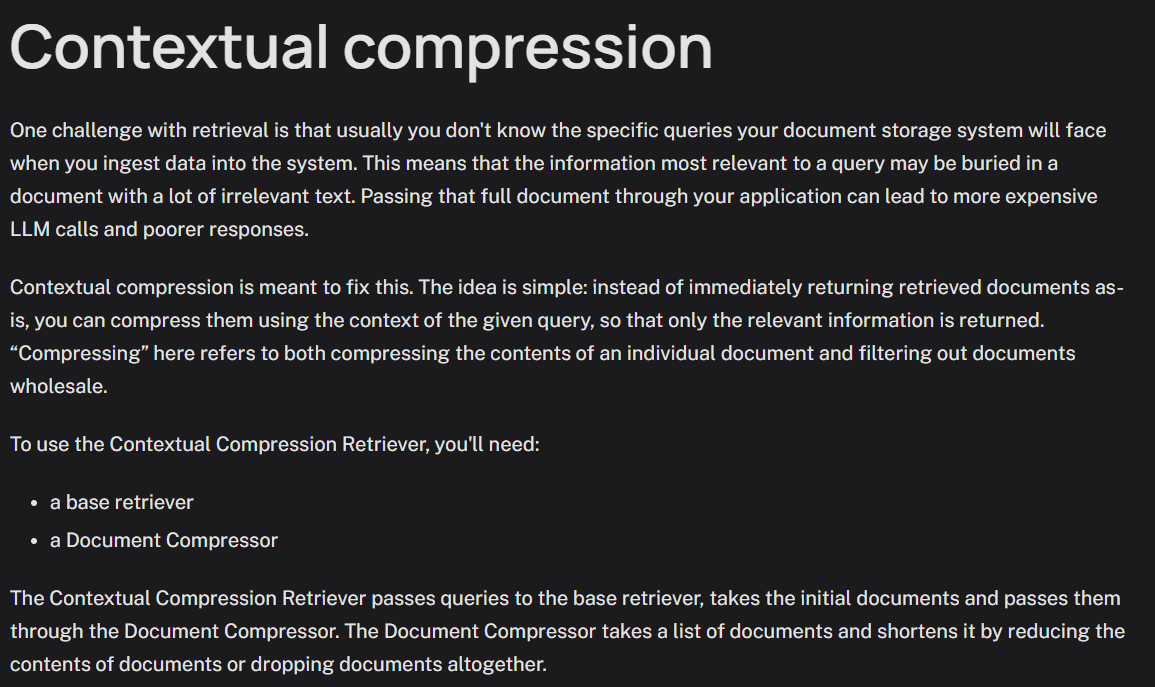

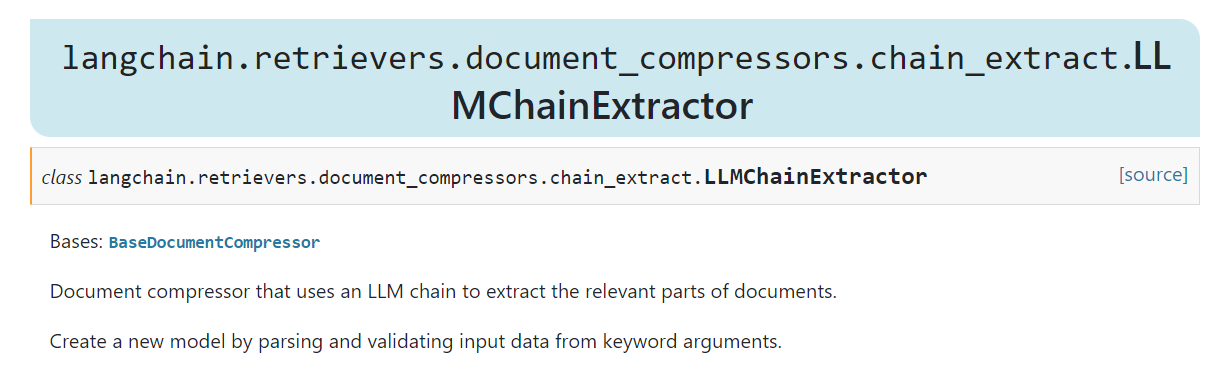

In [16]:
from langchain_google_genai import GoogleGenerativeAI
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# making the compressor
llm = GoogleGenerativeAI(model="gemini-1.5-pro")
compressor = LLMChainExtractor.from_llm(llm)

# it needs a base retriever (we're using FAISS Retriever) and a compressor (Made above)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor,
                                                       base_retriever=retriever)

In [17]:
# compressor prompt
compressor.llm_chain.prompt

PromptTemplate(input_variables=['context', 'question'], output_parser=NoOutputParser(), template='Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. \n\nRemember, *DO NOT* edit the extracted parts of the context.\n\n> Question: {question}\n> Context:\n>>>\n{context}\n>>>\nExtracted relevant parts:')

In [18]:
compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith?")
pretty_print_docs(compressed_docs)

Document 1:

Extracted relevant parts:

> Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications
----------------------------------------------------------------------------------------------------
Document 2:

LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.


## More built-in compressors: filters

### LLMChainFilter

Uses an LLM chain to select out the queries to show the final LLM - This could be shown to a model fine tuned to do this

"YES" we show it or "NO" we don't show it

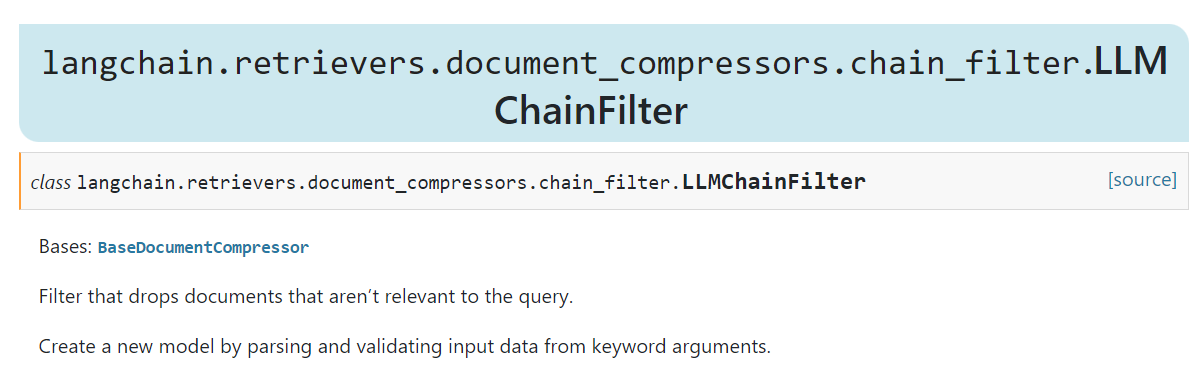

In [19]:
from langchain.retrievers.document_compressors import LLMChainFilter

_filter = LLMChainFilter.from_llm(llm)


In [20]:
_filter.llm_chain.prompt

PromptTemplate(input_variables=['context', 'question'], output_parser=BooleanOutputParser(), template="Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: {question}\n> Context:\n>>>\n{context}\n>>>\n> Relevant (YES / NO):")

In [26]:
compression_retriever = ContextualCompressionRetriever(base_compressor=_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("Why do I need to use LangSmith?")
pretty_print_docs(compressed_docs)

Document 1:

Debugging

LangSmith gives you full visibility into model inputs and output of every step in the chain of events. This makes it easy for teams to experiment with new chains and prompt templates, and spot the source of unexpected results, errors, or latency issues. We’ll also expose latency and token usage so that you can identify which calls are causing issues.

We’ve also made it easy to change and rerun examples from the UI. We added this feature after seeing teams take logs of bad examples and copy-paste into the OpenAI playground to tweak the prompt until they got a good result. We wanted to eliminate that friction, and now with the click of a button, you can go from a log to a playground where you can actively edit. This is currently supported for both OpenAI and Anthropic models, with support for more coming soon. We’re also working on supporting this for chains in general.
----------------------------------------------------------------------------------------------

### EmbeddingsFilter
Use an Embedding model to filter out the results that are closest to the query

In [27]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.76)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

Document 1:

URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.
----------------------------------------------------------------------------------------------------
Document 2:

“Because we are building financial products, the bar for accuracy, personalization, and security is particularl

## Pipelines


### Stringing compressors and document transformers together

DocumentCompressorPipeline allows us to string things together.

BaseDocumentTransformers - can do transformations on the docs -eg. split the text and

EmbeddingsRedundantFilter - filter out what is not related after a split or transformation



In [30]:
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=0, separator=". ")

redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)
relevant_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.76)

## making the pipeline
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

In [31]:
compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor,
                                                       base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

Document 1:

“Because we are building financial products, the bar for accuracy, personalization, and security is particularly high. LangSmith helps us build products we are confident putting in front of users.”

We can’t wait to bring these benefits to more teams. And we’ve got a long list of features on the roadmap like analytics, playgrounds, collaboration, in-context learning, prompt creation, and more.
----------------------------------------------------------------------------------------------------
Document 2:

URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working
---------------------------------------------------------------------

In [32]:
### different pipeline

## making the pipeline
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, compressor, redundant_filter, relevant_filter]
)

In [36]:
compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor,
                                                       base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

Document 1:

```
LangSmith gives you full visibility into model inputs and output of every step in the chain of events. This makes it easy for teams to experiment with new chains and prompt templates, and spot the source of unexpected results, errors, or latency issues. We’ll also expose latency and token usage so that you can identify which calls are causing issues.
```


## Examples Pipelines

**Example 1** - filter, rewrite, check with embeddings

**Example 2** - retrieve multiple sources [ensemble], filter, rewrite,

**Example 3** - retrieve, split, check splits with embeddings, filter, rewrite,